In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

In [4]:
public_bill = calc.public_bill
public_bill

2640560

In [5]:
_public_bill = public_bill / len(month_df)
_public_bill

24449.62962962963

# 기여도 산정

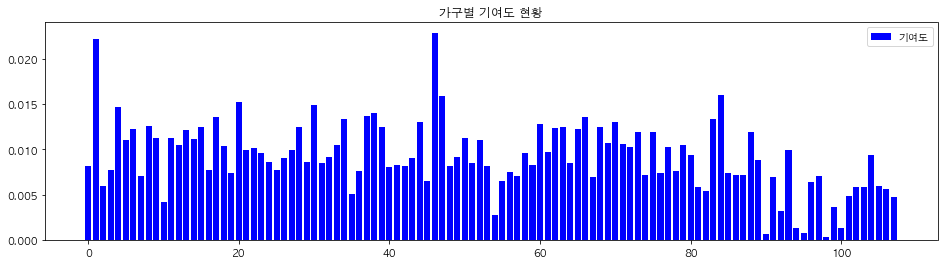

In [6]:
cont_df = month_df.copy()
households_kWh = cont_df['usage (kWh)'].sum()
cont_df['contribution'] = cont_df['usage (kWh)'] / households_kWh 

plt.figure(figsize=(16,4))

plt.bar(range(len(month_df)), cont_df['contribution'], color='b', label='기여도')
plt.title("가구별 기여도 현황")
plt.legend()

plt.show()

# 단순 가격분배

In [7]:
simple_cont = cont_df.copy()
simple_cont['단순 가격분배'] = round(public_bill * simple_cont['contribution']).astype("int")

simple_cont.head(10)

,name,usage (kWh),contribution,단순 가격분배
0,아파트1-101-1002,253,0.008134,21478
1,아파트1-101-104,689,0.022151,58492
2,아파트1-101-1102,183,0.005883,15536
3,아파트1-101-1202,239,0.007684,20290
4,아파트1-101-1302,455,0.014628,38627
5,아파트1-101-1401,343,0.011028,29119
6,아파트1-101-1403,380,0.012217,32260
7,아파트1-101-1502,219,0.007041,18592
8,아파트1-101-1504,389,0.012506,33024
9,아파트1-101-1602,350,0.011253,29713


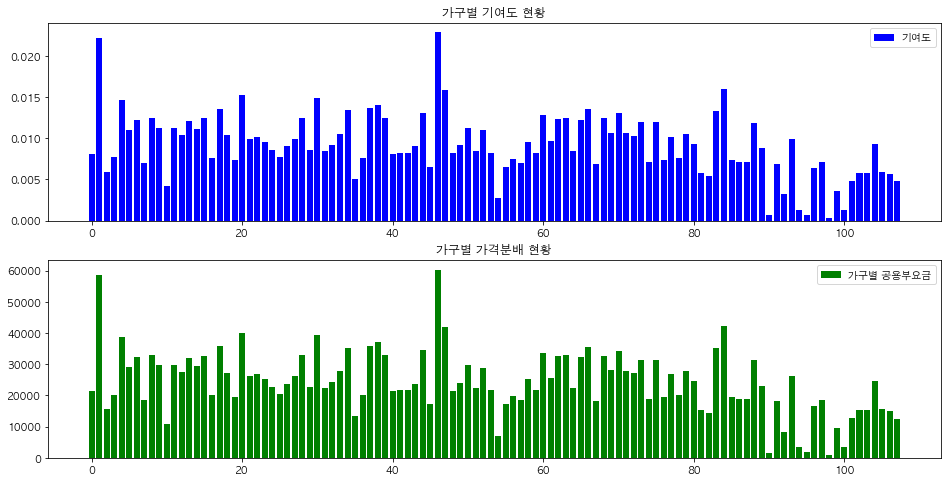

In [8]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(month_df)), cont_df['contribution'], color='b', label='기여도')
ax_1.set_title("가구별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), simple_cont['단순 가격분배'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [9]:
# 최소사용량 : 아파트1-104-905
# 평균사용량 : 아파트1-102-801
# 최대사용량 : 아파트1-102-903
min_h = simple_cont[simple_cont['name'] == '아파트1-104-905']
mean_h = simple_cont[simple_cont['name'] == '아파트1-102-801']
max_h = simple_cont[simple_cont['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),contribution,단순 가격분배
107,아파트1-104-905,148,0.004758,12564
43,아파트1-102-801,280,0.009002,23770
46,아파트1-102-903,711,0.022859,60360


# 기여도 공용부요금

In [10]:
dist_cont = cont_df.copy()

In [11]:
# 예측 시뮬레이션
pp = PublicPredictor(
    APT=APT,
    month_df=month_df,
    month=_month
)
pp.predict

실제 요금    2640560
예측 요금    2639700
오차           860
dtype: int64

In [12]:
dist_cont['기여도 공용부 기본요금'] = pp.basic * dist_cont['contribution']
dist_cont['기여도 공용부 전력량요금'] = pp.elec_rate * dist_cont['contribution']

dist_cont['기여도 공용부요금'] = (dist_cont['기여도 공용부 기본요금'] + dist_cont['기여도 공용부 전력량요금']).astype("int")

remain_public_bill = public_bill - dist_cont['기여도 공용부요금'].sum()

dist_cont['최종 공용부요금'] = (dist_cont['기여도 공용부요금'] + (remain_public_bill / len(month_df))).astype("int")
dist_cont.head(10)

,name,usage (kWh),contribution,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부요금,최종 공용부요금
0,아파트1-101-1002,253,0.008134,3735.052405,14577.547004,18312,21916
1,아파트1-101-104,689,0.022151,10171.743506,39699.327611,49871,53475
2,아파트1-101-1102,183,0.005883,2701.638696,10544.233603,13245,16849
3,아파트1-101-1202,239,0.007684,3528.369663,13770.884324,17299,20903
4,아파트1-101-1302,455,0.014628,6717.189108,26216.537101,32933,36537
5,아파트1-101-1401,343,0.011028,5063.727173,19763.235661,24826,28430
6,아파트1-101-1403,380,0.012217,5609.960134,21895.129887,27505,31109
7,아파트1-101-1502,219,0.007041,3233.108603,12618.509066,15851,19455
8,아파트1-101-1504,389,0.012506,5742.827611,22413.698753,28156,31760
9,아파트1-101-1602,350,0.011253,5167.068544,20166.567001,25333,28937


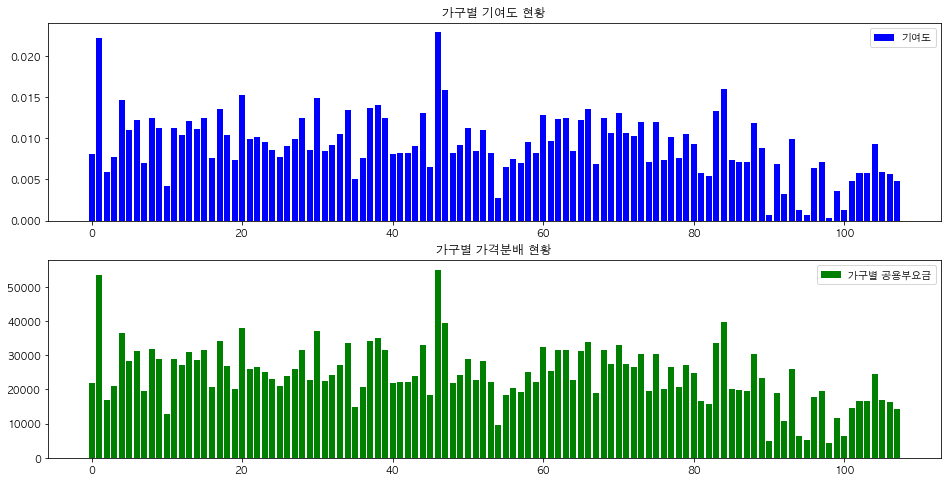

In [13]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(month_df)), cont_df['contribution'], color='b', label='기여도')
ax_1.set_title("가구별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), dist_cont['최종 공용부요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [14]:
# 최소사용량 : 아파트1-104-905
# 평균사용량 : 아파트1-102-801
# 최대사용량 : 아파트1-102-903
min_h = dist_cont[dist_cont['name'] == '아파트1-104-905']
mean_h = dist_cont[dist_cont['name'] == '아파트1-102-801']
max_h = dist_cont[dist_cont['name'] == '아파트1-102-903']

problem_dist_cont = pd.concat([min_h, mean_h, max_h])
problem_dist_cont

,name,usage (kWh),contribution,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부요금,최종 공용부요금
107,아파트1-104-905,148,0.004758,2184.931842,8527.576903,10712,14316
43,아파트1-102-801,280,0.009002,4133.654835,16133.253601,20266,23870
46,아파트1-102-903,711,0.022859,10496.530671,40966.940394,51463,55067


# 기여도를 적용비율로 이용

In [15]:
unknown_cont = cont_df.copy()
unknown_cont.head(10)

,name,usage (kWh),contribution
0,아파트1-101-1002,253,0.008134
1,아파트1-101-104,689,0.022151
2,아파트1-101-1102,183,0.005883
3,아파트1-101-1202,239,0.007684
4,아파트1-101-1302,455,0.014628
5,아파트1-101-1401,343,0.011028
6,아파트1-101-1403,380,0.012217
7,아파트1-101-1502,219,0.007041
8,아파트1-101-1504,389,0.012506
9,아파트1-101-1602,350,0.011253


In [16]:
unknown_cont['contribution'] = (unknown_cont['contribution'] - unknown_cont['contribution'].min()) / \
                        (unknown_cont['contribution'].max() - unknown_cont['contribution'].min())
unknown_cont.head(10)

,name,usage (kWh),contribution
0,아파트1-101-1002,253,0.346648
1,아파트1-101-104,689,0.968616
2,아파트1-101-1102,183,0.246790
3,아파트1-101-1202,239,0.326676
4,아파트1-101-1302,455,0.634807
5,아파트1-101-1401,343,0.475036
6,아파트1-101-1403,380,0.527817
7,아파트1-101-1502,219,0.298146
8,아파트1-101-1504,389,0.540656
9,아파트1-101-1602,350,0.485021


In [17]:
unknown_cont['기여도 공용부 기본요금'] = (pp.basic / len(cont_df)) * unknown_cont['contribution']
unknown_cont['기여도 공용부 전력량요금'] = (pp.elec_rate / len(cont_df)) * unknown_cont['contribution']

unknown_cont['기여도 공용부요금'] = (unknown_cont['기여도 공용부 기본요금'] + unknown_cont['기여도 공용부 전력량요금']).astype("int")
remain_public_bill = public_bill - unknown_cont['기여도 공용부요금'].sum()

unknown_cont['최종 공용부요금'] = (unknown_cont['기여도 공용부요금'] + (remain_public_bill / len(month_df))).astype("int")
unknown_cont.head(10)

,name,usage (kWh),contribution,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부요금,최종 공용부요금
0,아파트1-101-1002,253,0.346648,1473.862340,5752.341655,7226,23409
1,아파트1-101-104,689,0.968616,4118.323163,16073.415570,20191,36374
2,아파트1-101-1102,183,0.246790,1049.292941,4095.288503,5144,21327
3,아파트1-101-1202,239,0.326676,1388.948460,5420.931024,6809,22992
4,아파트1-101-1302,455,0.634807,2699.048317,10534.123606,13233,29416
5,아파트1-101-1401,343,0.475036,2019.737280,7882.838564,9902,26085
6,아파트1-101-1403,380,0.527817,2244.152533,8758.709516,11002,27185
7,아파트1-101-1502,219,0.298146,1267.642918,4947.487267,6215,22398
8,아파트1-101-1504,389,0.540656,2298.740027,8971.759206,11270,27453
9,아파트1-101-1602,350,0.485021,2062.194220,8048.543879,10110,26293


In [18]:
remain_public_bill / len(month_df)

16183.092592592593

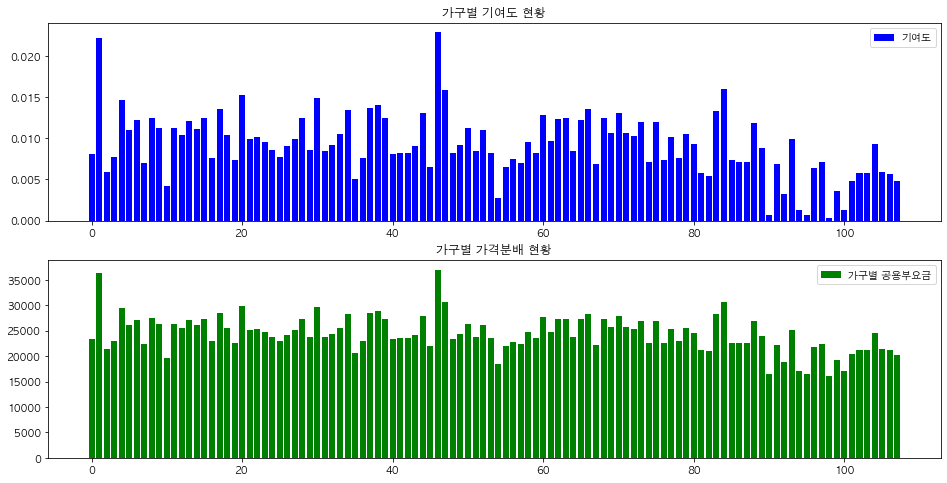

In [19]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(month_df)), cont_df['contribution'], color='b', label='기여도')
ax_1.set_title("가구별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), unknown_cont['최종 공용부요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [20]:
# 최소사용량 : 아파트1-104-905
# 평균사용량 : 아파트1-102-801
# 최대사용량 : 아파트1-102-903
min_h = unknown_cont[unknown_cont['name'] == '아파트1-104-905']
mean_h = unknown_cont[unknown_cont['name'] == '아파트1-102-801']
max_h = unknown_cont[unknown_cont['name'] == '아파트1-102-903']

problem_unknown_cont = pd.concat([min_h, mean_h, max_h])
problem_unknown_cont

,name,usage (kWh),contribution,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부요금,최종 공용부요금
107,아파트1-104-905,148,0.196862,837.008242,3266.761927,4103,20286
43,아파트1-102-801,280,0.385164,1637.624822,6391.490728,8029,24212
46,아파트1-102-903,711,1.000000,4251.759259,16594.203704,20845,37028


# 기여도를 적용비율로 이용 (non-normalization)

In [21]:
unknown_cont = cont_df.copy()
unknown_cont.head(10)

,name,usage (kWh),contribution
0,아파트1-101-1002,253,0.008134
1,아파트1-101-104,689,0.022151
2,아파트1-101-1102,183,0.005883
3,아파트1-101-1202,239,0.007684
4,아파트1-101-1302,455,0.014628
5,아파트1-101-1401,343,0.011028
6,아파트1-101-1403,380,0.012217
7,아파트1-101-1502,219,0.007041
8,아파트1-101-1504,389,0.012506
9,아파트1-101-1602,350,0.011253


In [22]:
unknown_cont['기여도 공용부 기본요금'] = (pp.basic / len(cont_df)) * unknown_cont['contribution']
unknown_cont['기여도 공용부 전력량요금'] = (pp.elec_rate / len(cont_df)) * unknown_cont['contribution']

unknown_cont['기여도 공용부요금'] = (unknown_cont['기여도 공용부 기본요금'] + unknown_cont['기여도 공용부 전력량요금']).astype("int")
remain_public_bill = public_bill - unknown_cont['기여도 공용부요금'].sum()

unknown_cont['최종 공용부요금'] = (unknown_cont['기여도 공용부요금'] + (remain_public_bill / len(month_df))).astype("int")
unknown_cont.head(10)

,name,usage (kWh),contribution,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부요금,최종 공용부요금
0,아파트1-101-1002,253,0.008134,34.583819,134.977287,169,24426
1,아파트1-101-104,689,0.022151,94.182810,367.586367,461,24718
2,아파트1-101-1102,183,0.005883,25.015173,97.631793,122,24379
3,아파트1-101-1202,239,0.007684,32.670089,127.508188,160,24417
4,아파트1-101-1302,455,0.014628,62.196195,242.745714,304,24561
5,아파트1-101-1401,343,0.011028,46.886363,182.992923,229,24486
6,아파트1-101-1403,380,0.012217,51.944075,202.732684,254,24511
7,아파트1-101-1502,219,0.007041,29.936191,116.838047,146,24403
8,아파트1-101-1504,389,0.012506,53.174330,207.534248,260,24517
9,아파트1-101-1602,350,0.011253,47.843227,186.727472,234,24491


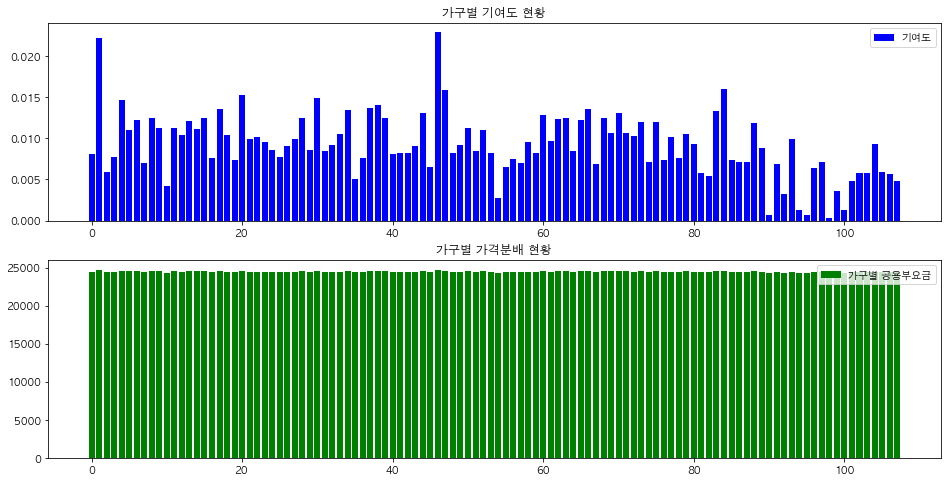

In [23]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(month_df)), cont_df['contribution'], color='b', label='기여도')
ax_1.set_title("가구별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), unknown_cont['최종 공용부요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [24]:
# 최소사용량 : 아파트1-104-905
# 평균사용량 : 아파트1-102-801
# 최대사용량 : 아파트1-102-903
min_h = unknown_cont[unknown_cont['name'] == '아파트1-104-905']
mean_h = unknown_cont[unknown_cont['name'] == '아파트1-102-801']
max_h = unknown_cont[unknown_cont['name'] == '아파트1-102-903']

problem_unknown_cont = pd.concat([min_h, mean_h, max_h])
problem_unknown_cont

,name,usage (kWh),contribution,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부요금,최종 공용부요금
107,아파트1-104-905,148,0.004758,20.230850,78.959045,99,24356
43,아파트1-102-801,280,0.009002,38.274582,149.381978,187,24444
46,아파트1-102-903,711,0.022859,97.190099,379.323522,476,24733


# 모든 가구들이 같은 사용량을 보여줬을 때

In [139]:
public_kWh = APT - month_df['usage (kWh)'].sum()

equity_md = month_df.copy()
equity_md['usage (kWh)'] = 150

APT_2 = equity_md['usage (kWh)'].sum() + public_kWh

calc = crs.models.ManagementOffice(
    month=_month,
    households=equity_md,
    APT=APT_2,
    contract="단일계약"
)
public_bill = calc.public_bill
public_bill

equity_md.head(10)

,name,usage (kWh)
0,아파트1-101-1002,150
1,아파트1-101-104,150
2,아파트1-101-1102,150
3,아파트1-101-1202,150
4,아파트1-101-1302,150
5,아파트1-101-1401,150
6,아파트1-101-1403,150
7,아파트1-101-1502,150
8,아파트1-101-1504,150
9,아파트1-101-1602,150


In [140]:
_public_bill = public_bill / len(month_df)
_public_bill

19753.796296296296

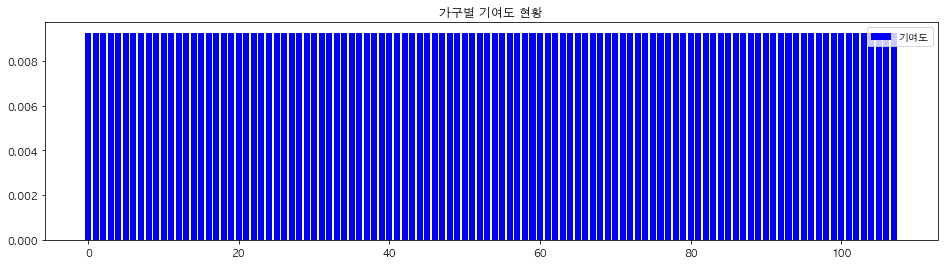

In [141]:
cont_df = equity_md.copy()
households_kWh = cont_df['usage (kWh)'].sum()
cont_df['contribution'] = cont_df['usage (kWh)'] / households_kWh 

plt.figure(figsize=(16,4))

plt.bar(range(len(month_df)), cont_df['contribution'], color='b', label='기여도')
plt.title("가구별 기여도 현황")
plt.legend()

plt.show()

## 단순 가격분배

In [145]:
simple_cont = cont_df.copy()
simple_cont['단순 가격분배'] = round(public_bill * simple_cont['contribution']).astype("int")

simple_cont.head(10)

,name,usage (kWh),contribution,단순 가격분배
0,아파트1-101-1002,150,0.009259,19754
1,아파트1-101-104,150,0.009259,19754
2,아파트1-101-1102,150,0.009259,19754
3,아파트1-101-1202,150,0.009259,19754
4,아파트1-101-1302,150,0.009259,19754
5,아파트1-101-1401,150,0.009259,19754
6,아파트1-101-1403,150,0.009259,19754
7,아파트1-101-1502,150,0.009259,19754
8,아파트1-101-1504,150,0.009259,19754
9,아파트1-101-1602,150,0.009259,19754


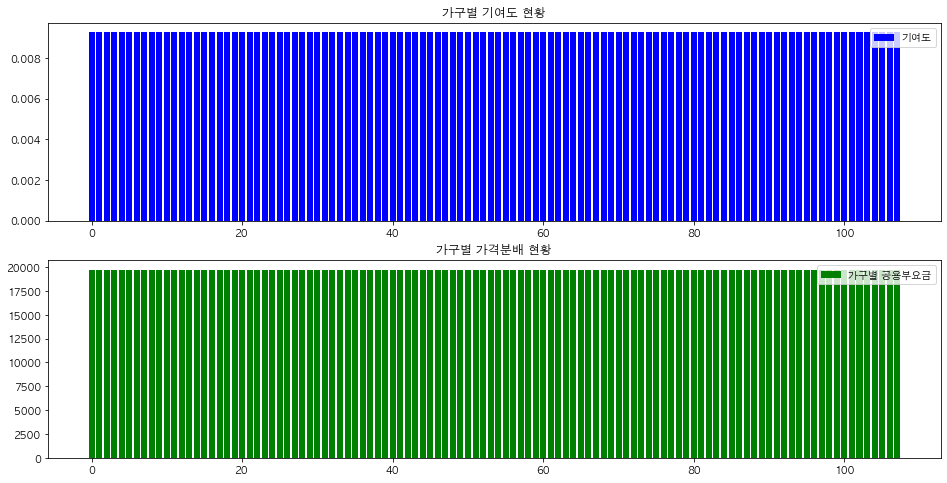

In [146]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(month_df)), cont_df['contribution'], color='b', label='기여도')
ax_1.set_title("가구별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), simple_cont['단순 가격분배'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

## 기여도 요금

In [147]:
dist_cont = cont_df.copy()

In [149]:
# 예측 시뮬레이션
pp = PublicPredictor(
    APT=APT_2,
    month_df=equity_md,
    month=_month
)
pp.predict

실제 요금    2133410
예측 요금    2132560
오차           850
dtype: int64

In [152]:
dist_cont['기여도 공용부 기본요금'] = pp.basic * dist_cont['contribution']
dist_cont['기여도 공용부 전력량요금'] = pp.elec_rate * dist_cont['contribution']

dist_cont['기여도 공용부요금'] = (dist_cont['기여도 공용부 기본요금'] + dist_cont['기여도 공용부 전력량요금']).round().astype("int")

remain_public_bill = public_bill - dist_cont['기여도 공용부요금'].sum()

dist_cont['최종 공용부요금'] = (dist_cont['기여도 공용부요금'] + (remain_public_bill / len(month_df))).round().astype("int")
dist_cont.head(10)

,name,usage (kWh),contribution,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부요금,최종 공용부요금
0,아파트1-101-1002,150,0.009259,530.0,14052.898148,14583,19754
1,아파트1-101-104,150,0.009259,530.0,14052.898148,14583,19754
2,아파트1-101-1102,150,0.009259,530.0,14052.898148,14583,19754
3,아파트1-101-1202,150,0.009259,530.0,14052.898148,14583,19754
4,아파트1-101-1302,150,0.009259,530.0,14052.898148,14583,19754
5,아파트1-101-1401,150,0.009259,530.0,14052.898148,14583,19754
6,아파트1-101-1403,150,0.009259,530.0,14052.898148,14583,19754
7,아파트1-101-1502,150,0.009259,530.0,14052.898148,14583,19754
8,아파트1-101-1504,150,0.009259,530.0,14052.898148,14583,19754
9,아파트1-101-1602,150,0.009259,530.0,14052.898148,14583,19754


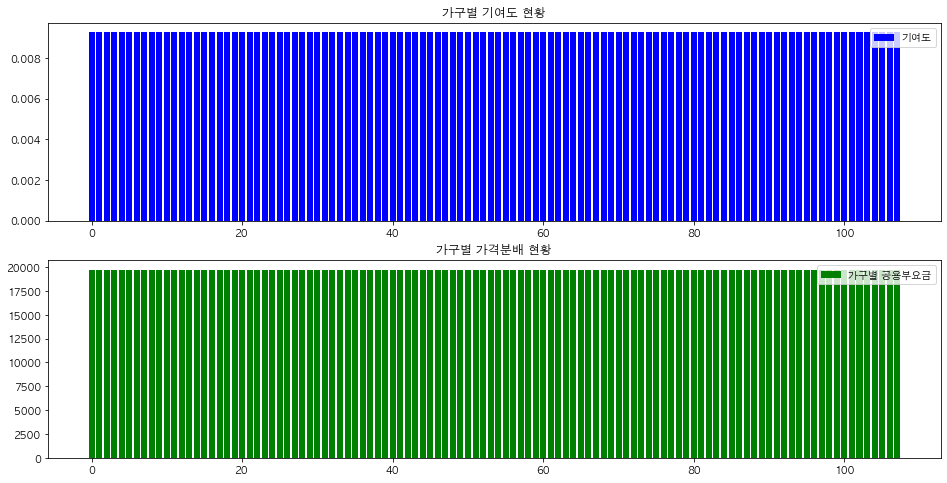

In [153]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(month_df)), cont_df['contribution'], color='b', label='기여도')
ax_1.set_title("가구별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), dist_cont['최종 공용부요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

## 기여도를 적용비율로 이용

In [154]:
unknown_cont = cont_df.copy()
unknown_cont.head(10)

,name,usage (kWh),contribution
0,아파트1-101-1002,150,0.009259
1,아파트1-101-104,150,0.009259
2,아파트1-101-1102,150,0.009259
3,아파트1-101-1202,150,0.009259
4,아파트1-101-1302,150,0.009259
5,아파트1-101-1401,150,0.009259
6,아파트1-101-1403,150,0.009259
7,아파트1-101-1502,150,0.009259
8,아파트1-101-1504,150,0.009259
9,아파트1-101-1602,150,0.009259


In [156]:
unknown_cont['contribution'] = 1
unknown_cont.head(10)

,name,usage (kWh),contribution
0,아파트1-101-1002,150,1
1,아파트1-101-104,150,1
2,아파트1-101-1102,150,1
3,아파트1-101-1202,150,1
4,아파트1-101-1302,150,1
5,아파트1-101-1401,150,1
6,아파트1-101-1403,150,1
7,아파트1-101-1502,150,1
8,아파트1-101-1504,150,1
9,아파트1-101-1602,150,1


In [158]:
unknown_cont['기여도 공용부 기본요금'] = (pp.basic / len(cont_df)) * unknown_cont['contribution']
unknown_cont['기여도 공용부 전력량요금'] = (pp.elec_rate / len(cont_df)) * unknown_cont['contribution']

unknown_cont['기여도 공용부요금'] = (unknown_cont['기여도 공용부 기본요금'] + unknown_cont['기여도 공용부 전력량요금']).round().astype("int")
remain_public_bill = public_bill - unknown_cont['기여도 공용부요금'].sum()

unknown_cont['최종 공용부요금'] = (unknown_cont['기여도 공용부요금'] + (remain_public_bill / len(month_df))).round().astype("int")
unknown_cont.head(10)

,name,usage (kWh),contribution,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부요금,최종 공용부요금
0,아파트1-101-1002,150,1,530.0,14052.898148,14583,19754
1,아파트1-101-104,150,1,530.0,14052.898148,14583,19754
2,아파트1-101-1102,150,1,530.0,14052.898148,14583,19754
3,아파트1-101-1202,150,1,530.0,14052.898148,14583,19754
4,아파트1-101-1302,150,1,530.0,14052.898148,14583,19754
5,아파트1-101-1401,150,1,530.0,14052.898148,14583,19754
6,아파트1-101-1403,150,1,530.0,14052.898148,14583,19754
7,아파트1-101-1502,150,1,530.0,14052.898148,14583,19754
8,아파트1-101-1504,150,1,530.0,14052.898148,14583,19754
9,아파트1-101-1602,150,1,530.0,14052.898148,14583,19754


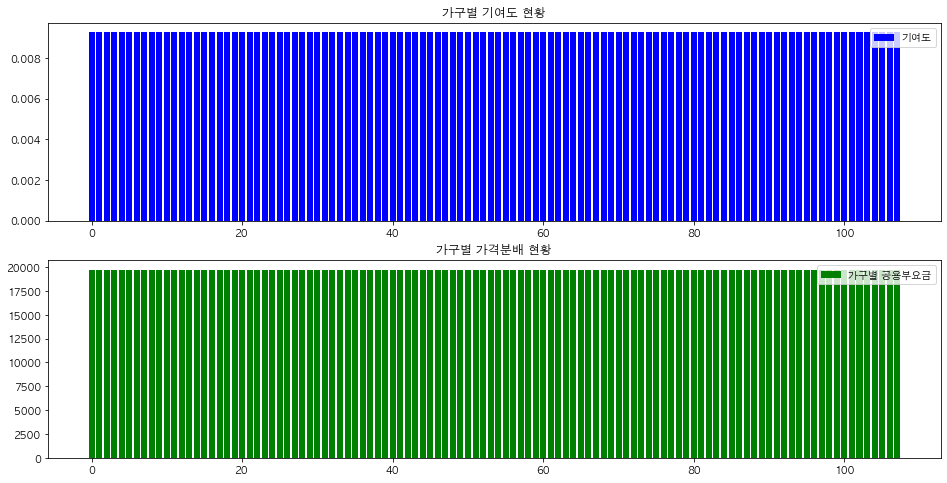

In [159]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(month_df)), cont_df['contribution'], color='b', label='기여도')
ax_1.set_title("가구별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), unknown_cont['최종 공용부요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()